### 02 Confirm SEM stage tilt rotation accuracy and repeatability
This notebook demonstrates the process for measuring the accuracy and repeatability of SEM stage in the tilt and rotation axes. 

#### Load dependent packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import kikuchipy as kp
from openECCI import util, io, rkp, stagecomputation

#### Load the four optimized correction coefficients calculated from 01_orientation_calibration notebook

In [2]:
optimized_correction_coefficients = {'tiltX_corr_angle': -0.41774066903384044, 
                                     'tiltY_corr_angle': 1.8230566479229673, 
                                     'tiltZ_corr_angle': 0.021146726033788282, 
                                     'PCz': 3.8888298036068742}

#### Load/locate the required data files
- Reference ECP from Si[001] wafer with no stage tilt or rotation
- Master pattern of Si simulated in EMsoft with the corresponding electron energy
- EBSD map file (.ctf is used) from the Si[001] wafer

In [3]:
# Path to Si ECP reference pattern
si_ref_ecp_path = Path("../openECCI-data/si_wafer/TFS_verios/")
si_ref_ecp_file = "Si_0tilt_0rot_008.tif"
si_ref_ecp_fname = os.path.join(si_ref_ecp_path, si_ref_ecp_file)
ref_ecp = plt.imread(si_ref_ecp_fname)

# Path to Si master pattern generated by EMsoft
si_MP_path = Path("../openECCI-data/ebsd_master_pattern/")
si_MP_file = "Si-master-20kv.h5"
si_MP_fname = os.path.join(si_MP_path, si_MP_file)
si_ECP_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to Si .ctf file containing the EBSD euler angles
si_xmap_path = Path("../openECCI-data/ebsd_map/")
si_xmap_file = "20kv_26nA_15mm WD_4x4 binning Si Map.ctf"
si_xmap_fname = os.path.join(si_xmap_path, si_xmap_file)

#### Load/locate the ECP from Si[001] wafer with different stage tilt and/or rotation angles

In [5]:
# Path to Si ECP experimental pattern
si_exp_ecp_path = Path("../openECCI-data/si_wafer/TFS_verios/")
si_exp_ecp_file = "Si_2tilt_0rot_003.tif"
si_exp_ecp_fname = os.path.join(si_exp_ecp_path, si_exp_ecp_file)
experiment_ecp = plt.imread(si_exp_ecp_fname)

#### Compare experimental ECP with simulated RKP at different stage tilt and/or rotation angles
Depending on the mechanical design of SEM stages, there could have some deviations in the real stage tilt/rotation angle from their displayed values due to backlashes. Therefore, by comparing the real orientation of the Si wafer (experimental ECP) and its expected orientation after stage tilt and/or rotation (simulated RKP), the stage accuracy and repeatability can be quantitatively evaluated.

In the following cell, relative stage tilt and rotation from where the reference ECP was acquired can be automatically calculated from their image metadata by using the `stagecomputation.get_relative_stage_pos` function. Note that this function is optimized and only validated for FEI/Thermofisher and Zeiss microscopes, in which the positive stage rotation in the software control is defined as clockwise rotation. If the two angle are manually calculated, it should be noted that `st_rot_angle` and `st_tilt_angle` used in the input of `rkp.get_sim_rkp` function are following the right hand rule in the reference frame of SEM (refer to the reference frame illustration in 01_orientation_calibration notebook). Therefore, a positive stage rotation of `st_rot_angle` is in the counter-clockwise direction.

By changing the Si ECP to the image files with different stage tilt and/or rotations, the stage orientation accuracy and repeatability can be confirmed.


stage rotation: 0.0, stage tilt: 2.0


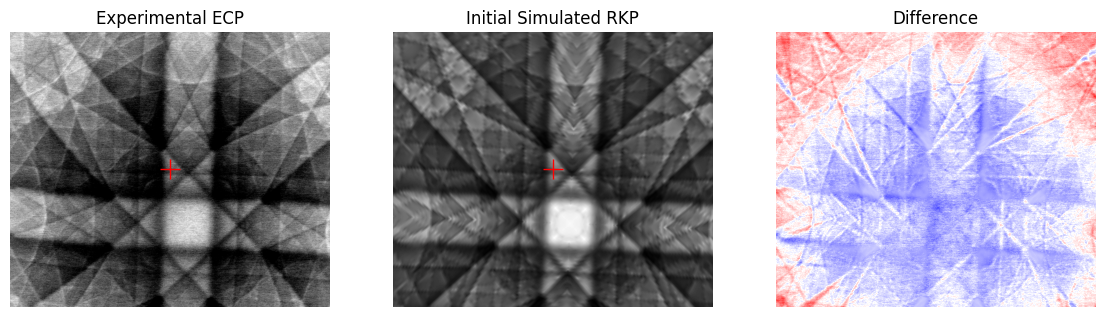

In [6]:
%matplotlib inline
# Get a approximate guess on the optimization parameters
tiltX_corr_angle_op = optimized_correction_coefficients["tiltX_corr_angle"] # positive direction => pattern moves DOWN
tiltY_corr_angle_op = optimized_correction_coefficients["tiltY_corr_angle"] # positive direction => pattern moves LEFT
tiltZ_corr_angle_op = optimized_correction_coefficients["tiltZ_corr_angle"] # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz_op = optimized_correction_coefficients["PCz"] # Larger value => smaller angular range

# get the stage rotation and tilt relative to the reference ECP
# angles used here are according to the testing reference frame rather than the SEM software rotation and tilt
st_rot_angle, st_tilt_angle, _, _, _ = stagecomputation.get_relative_stage_pos(si_ref_ecp_fname, si_exp_ecp_fname)

# read the average orientation of Si EBSD map
si_average_rotation = io.get_avg_orientation(si_xmap_fname)
ecp_resolution = io.get_sem_metadata(si_ref_ecp_fname)["resolution"]

# simulate the ECP using the initial guess
sim_RKP = rkp.get_sim_rkp(RKP_masterpattern = si_ECP_MP,
                              xtal_rotation = si_average_rotation,
                              st_rot_angle = st_rot_angle,
                              st_tilt_angle = st_tilt_angle,
                              corr_angles=[tiltX_corr_angle_op, tiltY_corr_angle_op, tiltZ_corr_angle_op],
                              ref_ECP=si_ref_ecp_fname,
                              PCz=PCz_op,
                              RKP_shape=ecp_resolution)

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,6))
ax1.imshow(experiment_ecp[:ecp_resolution[1],:], cmap='gray')
ax1.plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
ax1.set_title("Experimental ECP")
ax1.axis("off")

ax2.imshow(np.squeeze(sim_RKP.data), cmap='gray')
ax2.plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
ax2.set_title("Initial Simulated RKP")
ax2.axis("off")

ax3.imshow(util.normalize(experiment_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP.data)), cmap='bwr')
ax3.set_title("Difference")
ax3.axis("off")

print(f"stage rotation: {np.round(st_rot_angle, 2)}, stage tilt: {np.round(st_tilt_angle, 2)}")